# 导入必要的库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
import warnings
import time
import os
import scipy.io
from tqdm import tqdm
from solver import train, test
from plot import plot_loss
from eventDataset import eqkDataset
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
warnings.filterwarnings("ignore")
sns.set_style('ticks')
# sns.set()
sns.set_context("poster")
plt.rcParams['font.sans-serif'] = 'Times New Roman'
torch.set_default_tensor_type(torch.DoubleTensor)

# 数据预处理

## 导入数据

In [2]:
station = 'IBRH13'
dhacc = 981 * np.load(station + '_dhacc.npy')
upacc = 981 * np.load(station + '_upacc.npy')
# mdacc = 981 * np.load(station + '_mdacc.npy')
msg = np.load(station + '_msg.npy')

dt = 0.02
t = np.linspace(dt, dt * dhacc.shape[1], dhacc.shape[1])

## 数据标准化

In [3]:
# 用井下地震动的PGA进行数据标准化
PGA_dh = np.max(np.abs(dhacc), axis=1)
PGA_up = np.max(np.abs(upacc), axis=1)
for i in range(dhacc.shape[0]):
    dhacc[i, :] = dhacc[i, :] / PGA_dh[i]
    upacc[i, :] = upacc[i, :] / PGA_dh[i]

(Text(0.5, 0, 't (s)'),
 Text(0, 0.5, 'acc (gal)'),
 <matplotlib.legend.Legend at 0x26d82d685c8>)

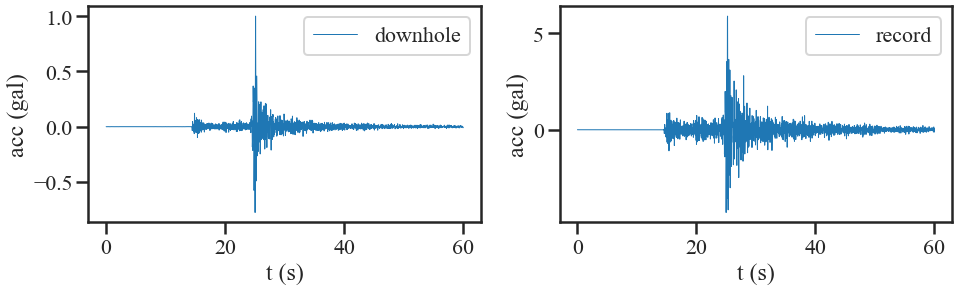

In [4]:
i = 23
t = np.linspace(0.02, 60, 3000)
plt.figure(figsize=((12, 3)))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.3,wspace=0.2)
plt.subplot(1, 2, 1)
plt.plot(t, dhacc[i, :], label='downhole', linewidth=1)
plt.xlabel('t (s)'), plt.ylabel('acc (gal)'), plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
# plt.plot(t, mdacc[i, :], '--', label='simulate', linewidth=1)
plt.plot(t, upacc[i, :], label='record', linewidth=1)
plt.xlabel('t (s)'), plt.ylabel('acc (gal)'), plt.legend(loc='upper right')

## 构造训练集、验证集和测试集

In [5]:
batch_size = 64
valid_size = 0.1
test_size = 0.1

numdata = dhacc.shape[0]
num_valid = int(valid_size * numdata)
num_test = int(test_size * numdata)
num_train = numdata - num_valid - num_test
index = list(range(numdata))
np.random.shuffle(index)
train_idx, valid_idx, test_idx = index[:num_train], index[num_train : num_train + num_valid], index[num_train + num_valid:]
# train_idx, valid_idx, test_idx = train_idx[0 : 500], valid_idx[0 : 15], test_idx[0 : 15]

data = scipy.io.loadmat(os.path.join(station + '_results', 'idx.mat'))
numdata = dhacc.shape[0]
index = list(range(numdata))
train_idx = data['train_idx'].ravel().tolist()
test_idx = data['test_idx'].ravel().tolist()
valid_idx = list(set(index) - set(train_idx) - set(test_idx))

train_data, train_label = dhacc[train_idx, :, None], upacc[train_idx, :, None]
valid_data, valid_label = dhacc[valid_idx, :, None], upacc[valid_idx, :, None]
test_data, test_label = dhacc[test_idx, :, None], upacc[test_idx, :, None]

train_dataset = eqkDataset(train_data, train_label)
valid_dataset = eqkDataset(valid_data, valid_label)
test_dataset = eqkDataset(test_data, test_label)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset)

## 绘制训练集和预测集数据的分布图

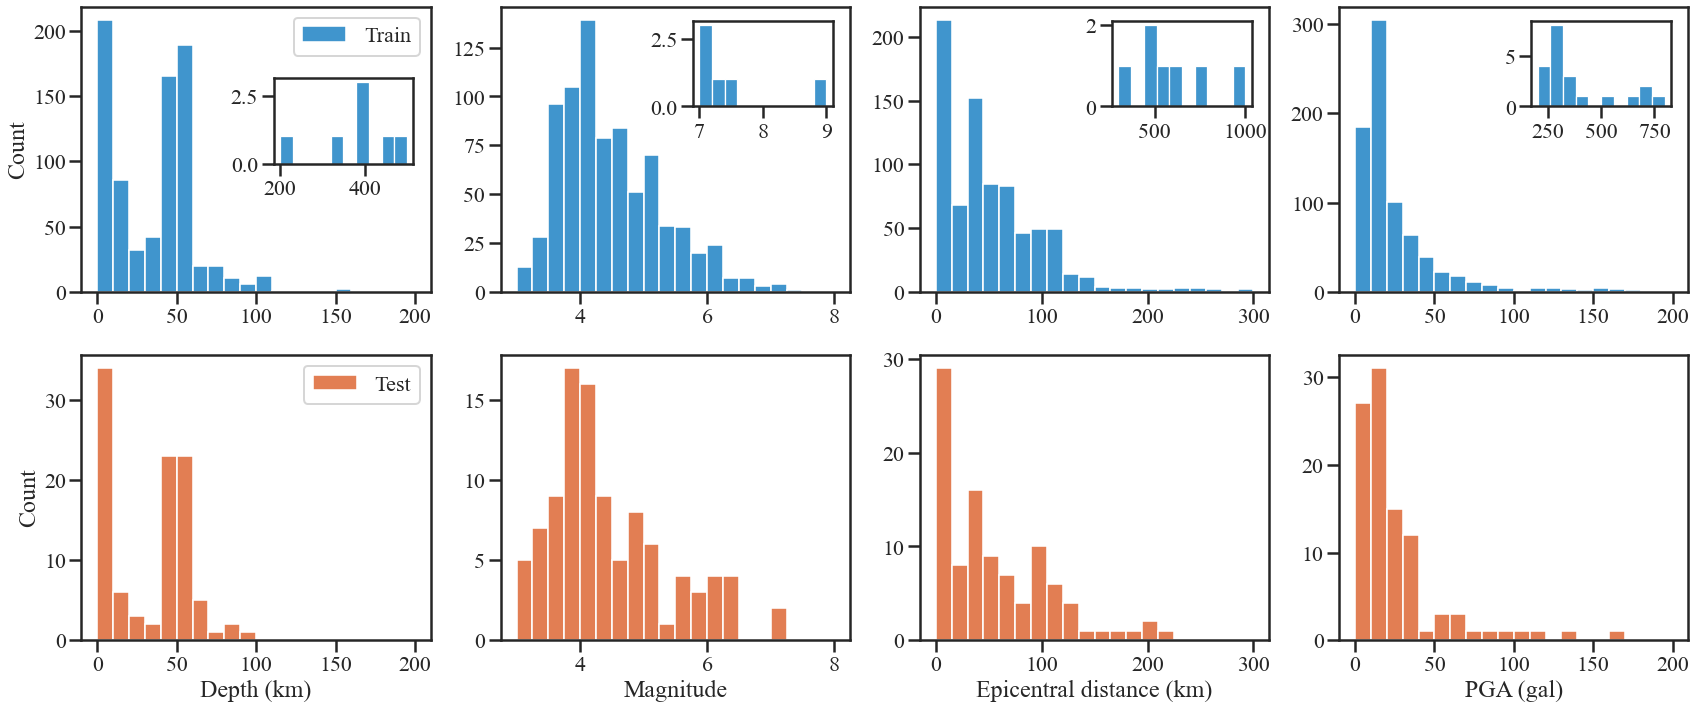

In [6]:
# data = scipy.io.loadmat(os.path.join(station + '_results', 'record_CNN', 'result.mat'))
# numdata = dhacc.shape[0]
# index = list(range(numdata))
# train_idx = data['train_idx'].ravel().tolist()
# test_idx = data['test_idx'].ravel().tolist()
# valid_idx = list(set(index) - set(train_idx) - set(test_idx))
with sns.axes_style('ticks'):
    sns.set_context("poster")
    plt.rcParams['font.sans-serif'] = 'Times New Roman'
    plt.figure(figsize=((24, 10)))
    plt.subplots_adjust(left=0.05,bottom=0.1,top=0.98,right=0.98,hspace=0.22,wspace=0.2)
    ax = plt.subplot(2, 4, 1)
    sns.histplot(msg[train_idx, 0], bins=20, binrange=[0, 200], color='#0072BD', label='Train')
    axins = ax.inset_axes((0.55, 0.45, 0.4, 0.3))
    sns.histplot(msg[train_idx, 0], bins=10, binrange=[200, 500], color='#0072BD', ax=axins)
    axins.set_ylabel('')
    plt.legend()
    ax = plt.subplot(2, 4, 5)
    sns.histplot(msg[test_idx, 0], bins=20, binrange=[0, 200], color='#D95319', label='Test')
    plt.xlabel('Depth (km)'), plt.legend()

    ax = plt.subplot(2, 4, 2)
    sns.histplot(msg[train_idx, 1], bins=20, binrange=[3, 8], color='#0072BD', label='Train')
    axins = ax.inset_axes((0.55, 0.65, 0.4, 0.3))
    sns.histplot(msg[train_idx, 1], bins=10, binrange=[7, 9], color='#0072BD', ax=axins)
    axins.set_ylabel('')
    plt.ylabel('')
    ax = plt.subplot(2, 4, 6)
    sns.histplot(msg[test_idx, 1], bins=20, binrange=[3, 8], color='#D95319', label='Test')
    plt.xlabel('Magnitude'), plt.ylabel('')

    ax = plt.subplot(2, 4, 3)
    sns.histplot(msg[train_idx, 2], bins=20, binrange=[0, 300], color='#0072BD', label='Train')
    axins = ax.inset_axes((0.55, 0.65, 0.4, 0.3))
    sns.histplot(msg[train_idx, 2], bins=10, binrange=[300, 1000], color='#0072BD', ax=axins)
    axins.set_ylabel('')
    plt.ylabel('')
    ax = plt.subplot(2, 4, 7)
    sns.histplot(msg[test_idx, 2], bins=20, binrange=[0, 300], color='#D95319', label='Test')
    plt.xlabel('Epicentral distance (km)'), plt.ylabel('')

    ax = plt.subplot(2, 4, 4)
    sns.histplot(msg[train_idx, 3], bins=20, binrange=[0, 200], color='#0072BD', label='Train')
    axins = ax.inset_axes((0.55, 0.65, 0.4, 0.3))
    sns.histplot(msg[train_idx, 3], bins=10, binrange=[200, 800], color='#0072BD', ax=axins)
    axins.set_ylabel('')
    plt.ylabel('')
    ax = plt.subplot(2, 4, 8)
    sns.histplot(msg[test_idx, 3], bins=20, binrange=[0, 200], color='#D95319', label='Test')
    plt.xlabel('PGA (gal)'), plt.ylabel('')
    plt.savefig(os.path.join(station + '_results', 'record_CNN', 'data.svg'))

# 深度学习模型构建

## 网络结构搭建

In [7]:

class PhyCNN(nn.Module):
    def __init__(self):
        super(PhyCNN, self).__init__()
        n = 3000
        phi1 = np.concatenate([np.array([-3 / 2, 2, -1 / 2]), np.zeros([n - 3, ])])
        temp1 = np.concatenate([-1 / 2 * np.identity(n - 2), np.zeros([n - 2, 2])], axis=1)
        temp2 = np.concatenate([np.zeros([n - 2, 2]), 1 / 2 * np.identity(n - 2)], axis=1)
        phi2 = temp1 + temp2
        phi3 = np.concatenate([np.zeros([n - 3, ]), np.array([1 / 2, -2, 3 / 2])])
        Phi_t = 1 / dt * np.concatenate([np.reshape(phi1, [1, phi1.shape[0]]), phi2, np.reshape(phi3, [1, phi3.shape[0]])], axis=0)
        Phi_t = torch.tensor(Phi_t)
        if torch.cuda.is_available():
            Phi_t = Phi_t.cuda()
        self.Phi_t = Phi_t
        self.cnnlayer = nn.Sequential(
            nn.Conv1d(1, 4, 101, bias=True, padding=50),
            # nn.Sigmoid(),
            nn.Tanh(),
            # nn.ReLU(inplace=True),
            nn.Conv1d(4, 16, 101, bias=True, padding=50),
            # nn.Sigmoid(),
            nn.Tanh(),
            # nn.ReLU(inplace=True),
            nn.Conv1d(16, 64, 101, bias=True, padding=50),
            # nn.Sigmoid(),
            # nn.Tanh(),
            # # nn.ReLU(inplace=True),
            # nn.Conv1d(16, 32, 101, bias=True, padding=50),
            # nn.Tanh(),
            # # nn.ReLU(inplace=True),
            # nn.Conv1d(32, 64, 101, bias=True, padding=50),
            nn.Tanh()
            # nn.ReLU(inplace=True)
        )

        self.fc = nn.Sequential(
            nn.Linear(64, 16),
            # nn.Tanh(),
            nn.ReLU(inplace=True),
            nn.Linear(16, 4),
            # nn.Tanh(),
            nn.ReLU(inplace=True),
            nn.Linear(4, 1)
        )
        # self._initial_parameters()
        

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnnlayer(x)
        x = x.permute(0, 2, 1)
        x = self.fc(x)
        x_t = torch.matmul(self.Phi_t, x[:, :, 0].permute(1, 0))
        x_tt = torch.matmul(self.Phi_t, x_t)
        x_tt = x_tt.permute(1, 0)
        return x_tt[:, :, None]
    
    
    def _initial_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.constant_(p, 0.01)
            else:
                nn.init.constant_(p, 0)

## 定义loss函数

In [8]:

def PhyCNNLoss(output, target):
    # PGA = torch.max(torch.abs(output_tt))/100
    # loss = torch.mean((output_tt/PGA - target/PGA).pow(2))
    # loss = torch.mean(((output - target)/torch.max(torch.abs(target))).pow(2))
    loss = torch.mean((output - target).pow(2))
    # corr = 1 - (torch.sum((output - torch.mean(output) * (target - torch.mean(target))))).pow(2) / ((torch.sum((output - torch.mean(output)).pow(2))) * (torch.sum((target - torch.mean(target)).pow(2))))
    # MSE = torch.mean((output - target).pow(2))
    # loss = corr + MSE
    # loss = torch.mean((output_tt - target).pow(2)) + torch.mean(output.pow(2))
    return loss

## 进行训练

In [9]:
max_epoch = 1000
disp_freq = -1
learning_rate = 0.001
Net = PhyCNN()
# GPU加速
if torch.cuda.is_available():
    Net = Net.cuda()
# optimizer = torch.optim.LBFGS(Net.parameters(), lr=learning_rate, max_iter=2)
optimizer = torch.optim.Adam(Net.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
starttime = time.time()
train_best_model ,valid_best_model, last_model, train_loss, valid_loss = train(Net, PhyCNNLoss, optimizer, train_loader, valid_loader, max_epoch, disp_freq)
print('Training Time {:.4f}'.format(time.time()-starttime))
prediction = test(valid_best_model, PhyCNNLoss, test_loader)
torch.cuda.empty_cache()

Epoch [1/1000]	 Average training and validation loss: 1.8505E+00 6.1361E-01	Time: 10.80s
Epoch [2/1000]	 Average training and validation loss: 5.5854E-01 5.4140E-01	Time: 9.30s
Epoch [3/1000]	 Average training and validation loss: 5.0410E-01 5.1003E-01	Time: 9.29s
Epoch [4/1000]	 Average training and validation loss: 4.8372E-01 4.9943E-01	Time: 9.30s
Epoch [5/1000]	 Average training and validation loss: 4.7499E-01 4.9435E-01	Time: 9.29s
Epoch [6/1000]	 Average training and validation loss: 4.7265E-01 4.9244E-01	Time: 9.30s
Epoch [7/1000]	 Average training and validation loss: 4.7197E-01 4.9213E-01	Time: 9.29s
Epoch [8/1000]	 Average training and validation loss: 4.7169E-01 4.9210E-01	Time: 9.31s
Epoch [9/1000]	 Average training and validation loss: 4.7167E-01 4.9200E-01	Time: 9.30s
Epoch [10/1000]	 Average training and validation loss: 4.7169E-01 4.9190E-01	Time: 9.29s
Epoch [11/1000]	 Average training and validation loss: 4.7171E-01 4.9191E-01	Time: 9.30s
Epoch [12/1000]	 Average trai

## 绘制loss变化曲线

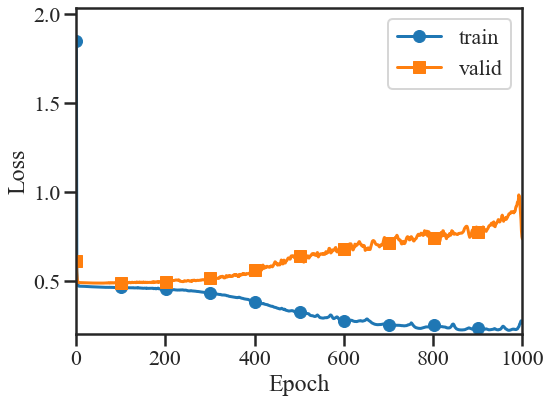

In [10]:
plot_loss(train_loss, valid_loss)
torch.save(train_best_model, os.path.join(station + '_results', 'record_CNN', 'trainbest.pt'))
torch.save(valid_best_model, os.path.join(station + '_results', 'record_CNN', 'validbest.pt'))
torch.save(last_model, os.path.join(station + '_results', 'record_CNN', 'last.pt'))

# 结果处理

In [11]:
valid_best_model = torch.load(os.path.join(station + '_results', 'record_CNN', 'last.pt'))

## 训练集上的结果

### 训练集结果计算

In [12]:
train_pred = np.zeros(train_label.shape)
pbar = tqdm(range(train_data.shape[0]), desc='计算中', ncols=100)
for i in pbar:
    y = valid_best_model(torch.tensor(train_data[i:i+1, :, :]).cuda())
    train_pred[i, :, :] = y.cpu().detach().numpy()
    train_data[i, :, 0] = train_data[i, :, 0] * PGA_dh[train_idx[i]]
    train_pred[i, :, 0] = train_pred[i, :, 0] * PGA_dh[train_idx[i]]
    train_label[i, :, 0] = train_label[i, :, 0] * PGA_dh[train_idx[i]]

计算中: 100%|█████████████████████████████████████████████████████| 802/802 [00:13<00:00, 59.92it/s]


### 训练集结果绘图

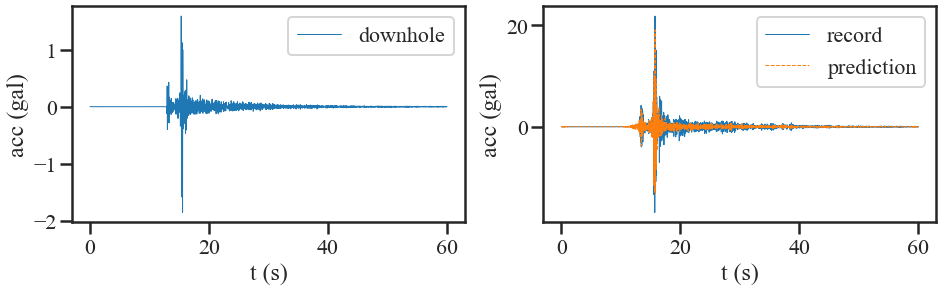

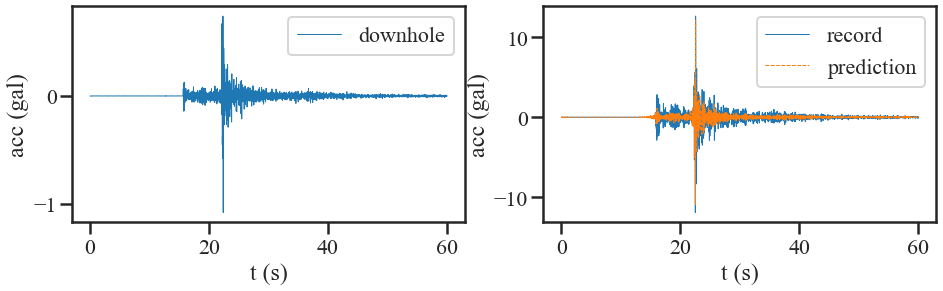

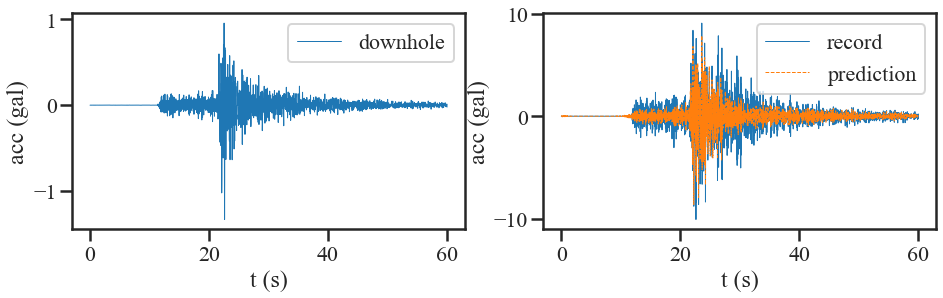

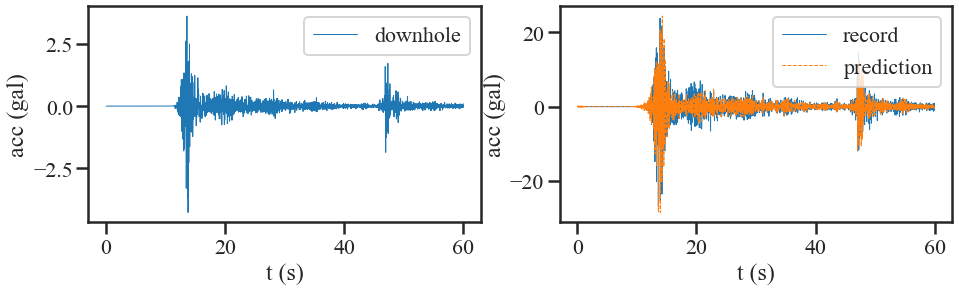

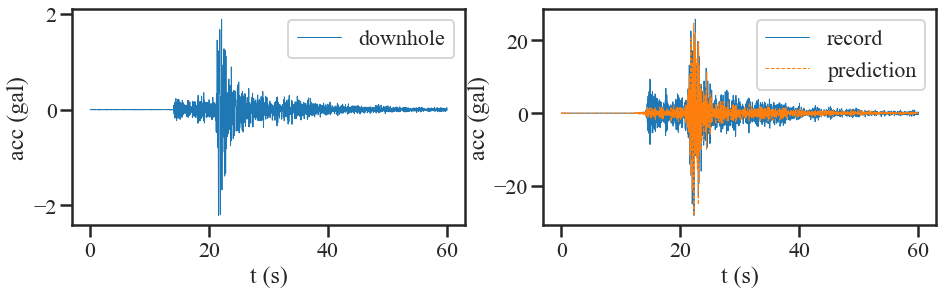

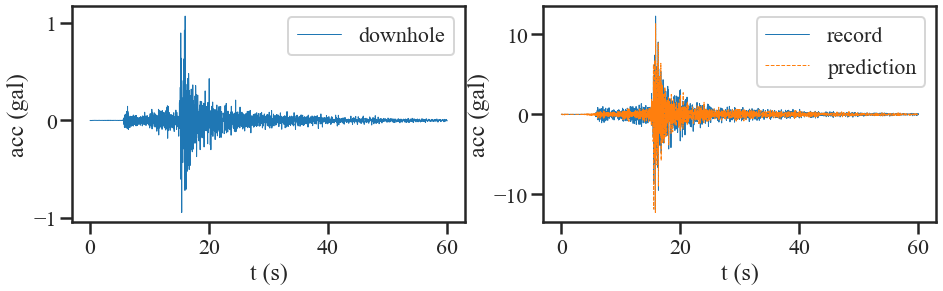

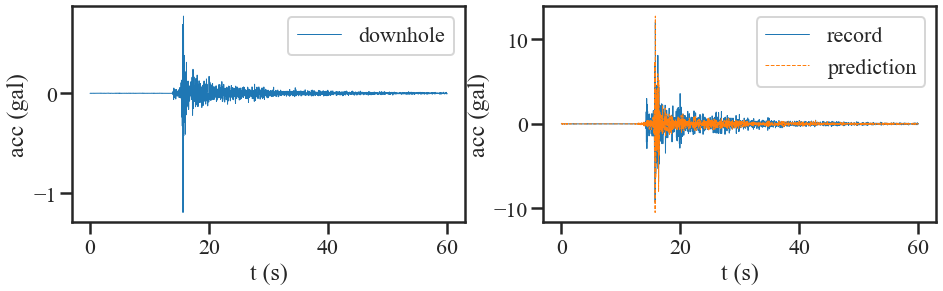

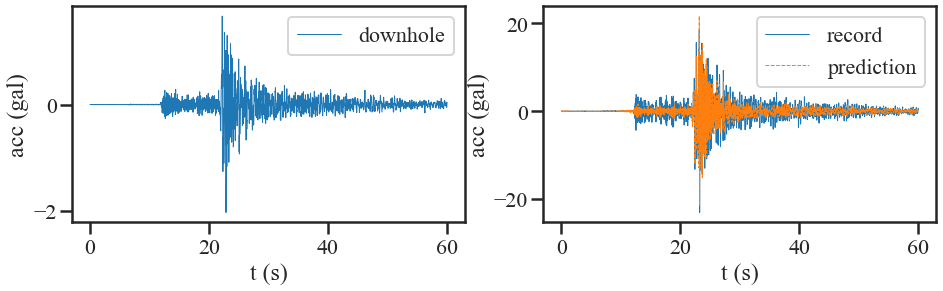

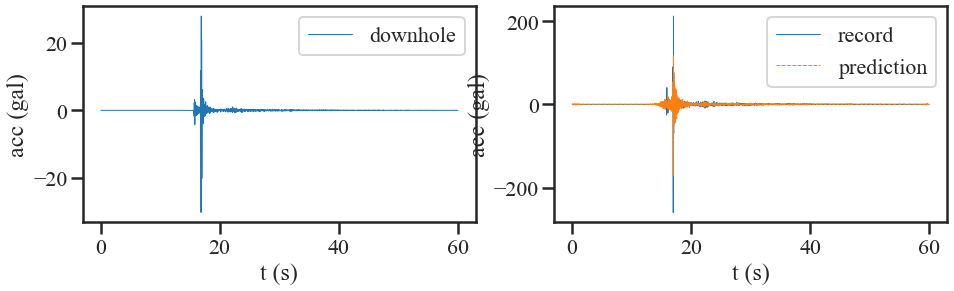

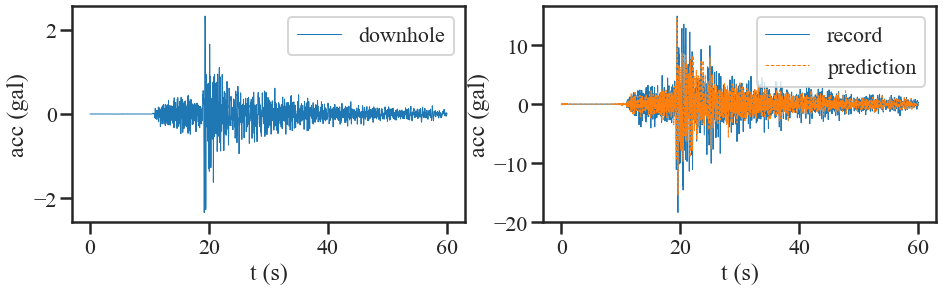

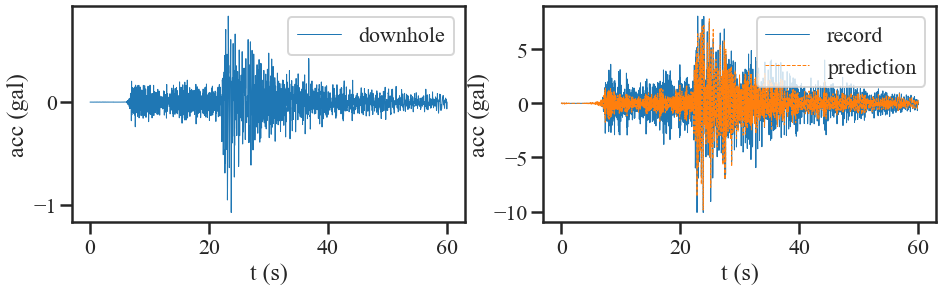

In [13]:
dof = 0
# for i in range(0, train_pred.shape[0]):
for i in range(0, train_pred.shape[0], int(train_pred.shape[0] / 10)):
    plt.figure(figsize=((12, 3)))
    plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.3,wspace=0.2)
    plt.subplot(1, 2, 1)
    plt.plot(t, train_data[i, :, dof], label='downhole', linewidth=1)
    plt.xlabel('t (s)'), plt.ylabel('acc (gal)'), plt.legend(loc='upper right')
    plt.subplot(1, 2, 2)
    plt.plot(t, train_label[i, :, dof], label='record', linewidth=1)
    plt.plot(t, train_pred[i, :, dof], '--', label='prediction', linewidth=1)
    plt.xlabel('t (s)'), plt.ylabel('acc (gal)'), plt.legend(loc='upper right')
    # plt.savefig(os.path.join(station + '_results', 'record_CNN', 'figures', 'train{:d}.svg'.format(i)))
    # plt.close()

## 测试集上的结果

### 测试集结果计算

In [14]:
test_pred = valid_best_model(torch.tensor(test_data).cuda())
test_pred = test_pred.cpu().detach().numpy()
for i in range(test_data.shape[0]):
    test_data[i, :, 0] = test_data[i, :, 0] * PGA_dh[test_idx[i]]
    test_label[i, :, 0] = test_label[i, :, 0] * PGA_dh[test_idx[i]]
    test_pred[i, :, 0] = test_pred[i, :, 0] * PGA_dh[test_idx[i]]
torch.cuda.empty_cache()

### 测试集结果绘图

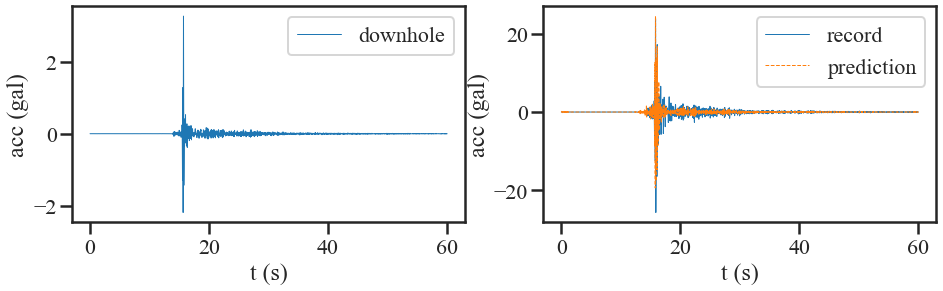

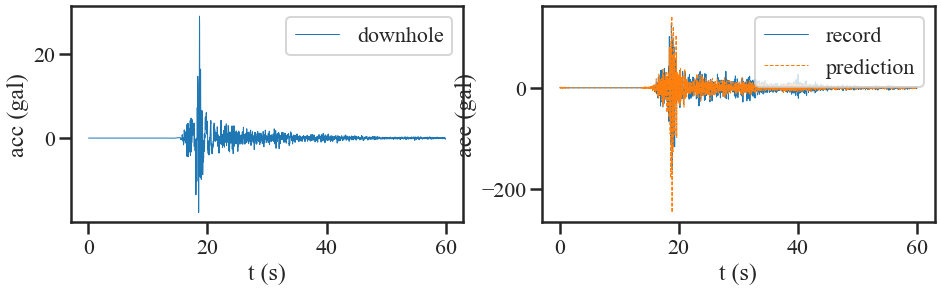

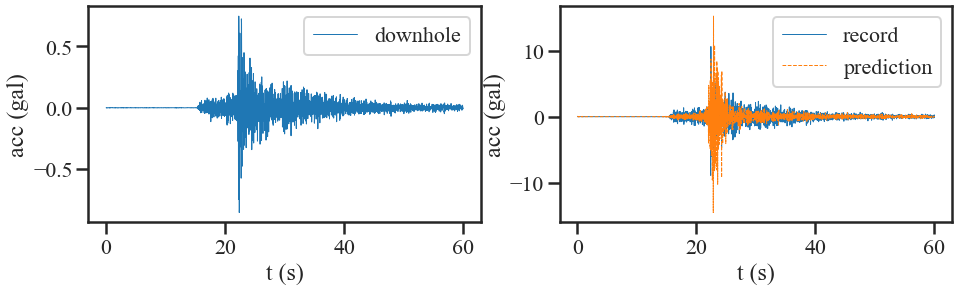

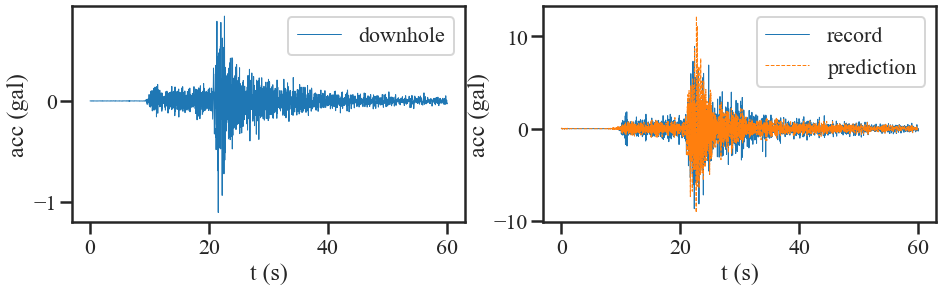

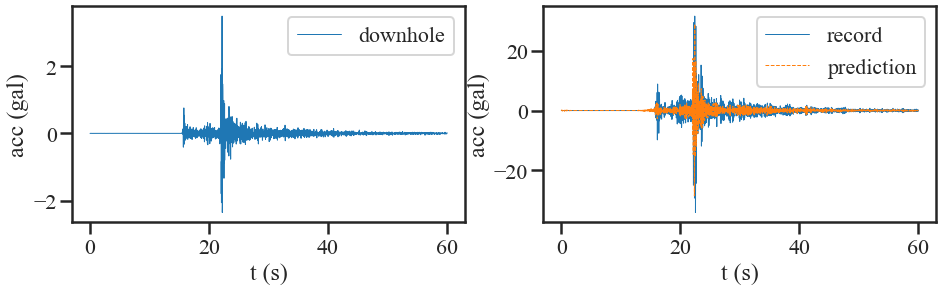

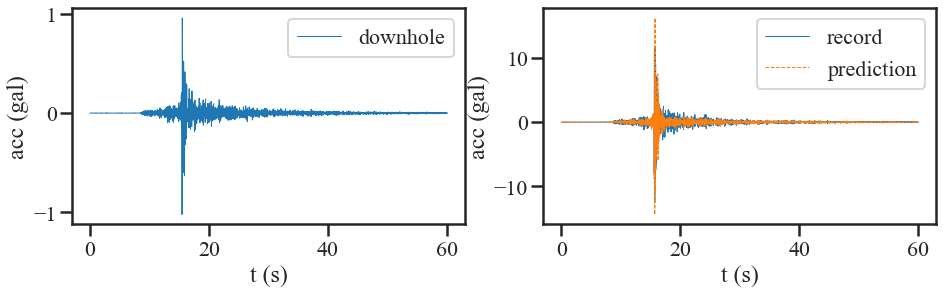

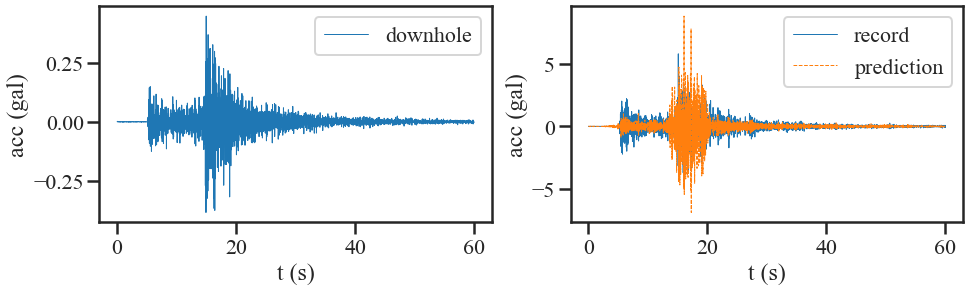

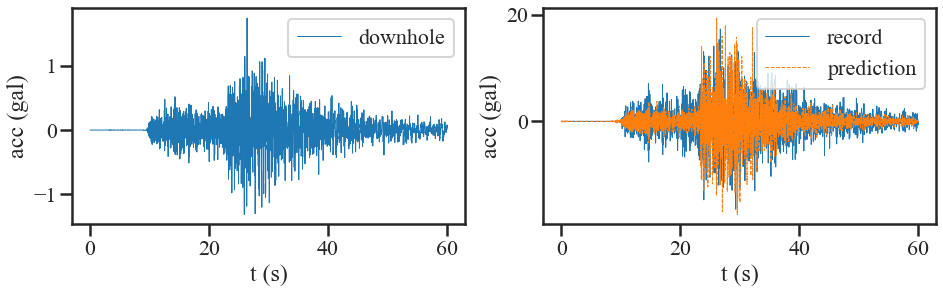

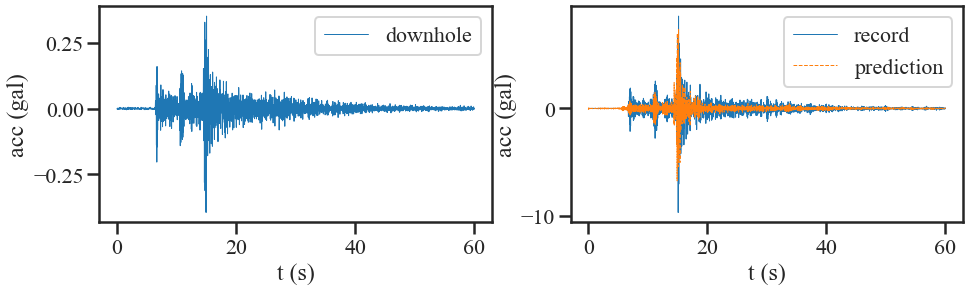

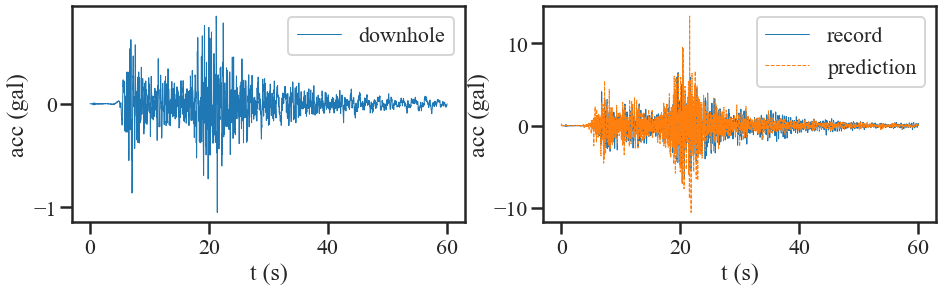

In [15]:
dof = 0
for i in range(0, test_pred.shape[0], int(test_pred.shape[0]/10)):
# for i in range(0, test_pred.shape[0]):
    plt.figure(figsize=((12, 3)))
    plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.3,wspace=0.2)
    plt.subplot(1, 2, 1)
    plt.plot(t, test_data[i, :, dof], label='downhole', linewidth=1)
    plt.xlabel('t (s)'), plt.ylabel('acc (gal)'), plt.legend(loc='upper right')
    plt.subplot(1, 2, 2)
    plt.plot(t, test_label[i, :, dof], label='record', linewidth=1)
    plt.plot(t, test_pred[i, :, dof], '--', label='prediction', linewidth=1)
    plt.xlabel('t (s)'), plt.ylabel('acc (gal)'), plt.legend(loc='upper right')
    # plt.savefig(os.path.join(station + '_results', 'record_CNN', 'figures', 'test{:d}.svg'.format(i)))
    # plt.close()

## 保存结果数据

In [16]:
scipy.io.savemat(os.path.join(station + '_results', 'record_CNN', 'result0405.mat'), {'train_data': train_data, 'train_idx': train_idx, 'valid_idx': valid_idx, 'test_idx': test_idx, 'train_label': train_label, 'train_pred': train_pred, 'test_data': test_data, 'test_label': test_label, 'test_pred': test_pred, 'train_loss': train_loss, 'valid_loss': valid_loss, 'time': t, 'dt': dt})